# ML in Cybersecurity: Task 3

## Team
  * **Team name**:  *R2D2C3P0BB8*
  * **Members**:  <br/> **Navdeeppal Singh (s8nlsing@stud.uni-saarland.de)** <br/> **Shahrukh Khan (shkh00001@stud.uni-saarland.de)** <br/> **Mahnoor Shahid (mash00001@stud.uni-saarland.de)**


## Logistics
  * **Due date**: 9th December 2021, 23:59:59
  * Email the completed notebook to: `mlcysec_ws2022_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the forum to discuss.
  
## Timeline
  * 26-Nov-2021: hand-out
  * **09-Dec-2021**: Email completed notebook
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal is to train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use the final summary to provide a report about these.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 
import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path

import glob
import pandas as pd
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, naive_bayes
from torch.utils.data import DataLoader, random_split

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`
  * Hint: you can execute shell scripts from notebooks using the `!` prefix, e.g., `! wget <url>`

In [3]:
# Check that you are prepared with the data
! echo '# train examples (Should be 13682) : '; ls -type f -print data/train | wc -l
! printf '# test  examples (Should be 10000) : '; ls data/test | wc -l

'wc' is not recognized as an internal or external command,
operable program or batch file.
'printf' is not recognized as an internal or external command,
operable program or batch file.


Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data

In [4]:

def load_content(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    lines = open(filepath,'r').readlines()
    string1 = "" 
    for row in lines:
        if not '#' in row:
            row = row.replace(' |',' ').strip(' \n')
            string1=string1+row
    label = str.split(filepath,'.')[-1]
    return label, string1


def load_data(data_path, nworkers=10):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    keys = []
    records=[]
    all_files = glob.glob(str(data_path) + '/*')
    pool = Pool(processes=4)
    for file in all_files[:5000]:
        # labels, lines = pool.map(load_content, (file))
        labels, lines = load_content(file)
        keys.append(labels)
        records.append(lines)
    raw_data_samples = {'label': keys, 'lines': records  }
    return raw_data_samples    

In [5]:
print('=> Loading training data ... ')
train_raw_samples = load_data(Path('./data/train'))

=> Loading training data ... 


In [6]:
len(train_raw_samples['label'])

5000

In [7]:
# train_raw_samples['lines'][:2]

In [8]:
type(train_raw_samples)

dict

In [9]:
def plot_classification(dff, classes):
    data[classes].value_counts().plot(kind='bar', color= 'skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Malware')
    plt.title("Frequency Count of Malware Classes")   

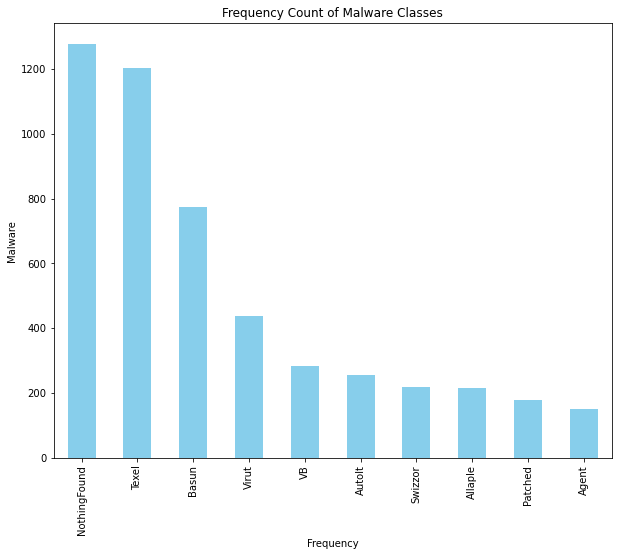

In [10]:
data = pd.DataFrame(train_raw_samples)
plot_classification(data, classes='label')

In [11]:
def reset_df(dff):
    dff = dff.reset_index()
    dff = dff.drop(columns=['index'])
    return dff

In [12]:
def split_dataset(dict_samples, validate_size = 0.2, test=False):
    dff = pd.DataFrame(dict_samples)
    if test == False:
        train_samples, validate_samples = train_test_split(dff, test_size = validate_size)
        train_samples = reset_df(train_samples)
        validate_samples = reset_df(validate_samples)
        return  train_samples, validate_samples
    else:
        test_samples = reset_df(dff)
        return  test_samples

In [13]:
project_mode = 'traintest'    # trainval, traintest, debug
np.random.seed(123)          # To perform the same split across multiple runs

if project_mode == 'trainval':
    train_samples, validate_samples = split_dataset(train_raw_samples, validate_size = 0.25)
    # mask = int(len(train_raw_samples))
    # train_samples, validate_samples = random_split(train_raw_samples, [int(0.8*mask), int(0.2*mask)])
    print(f'Training Samples {train_samples.shape}')
    print(f'Validation Samples {validate_samples.shape}')

elif project_mode == 'traintest':
    train_samples, _ = split_dataset(train_raw_samples, validate_size = 0.2)
    test_raw_samples = load_data(Path('./data/test/test'))
    test_samples = split_dataset(test_raw_samples, validate_size = 0.0, test =True)
    print(f'Training Samples {train_samples.shape}')
    print(f'Testing Samples {test_samples.shape}')

elif project_mode == 'debug':
    # Optional, use a small subset of the training and validation data for fast debugging
    pass
else:
    raise ValueError('Unrecognized mode')
    
print('=> # Train samples = ', len(train_samples))
print('=> # Test samples = ', len(test_samples))

Training Samples (4000, 2)
Testing Samples (5000, 2)
=> # Train samples =  4000
=> # Test samples =  5000


In [14]:
train_samples

,label,lines
0,Texel,02 01 000006c8 0000066a 0000500002 02 00006b...
1,VB,02 01 000006c8 0000066a 0001a00002 02 00006b...
2,NothingFound,02 01 000006c8 0000066a 0000b00002 02 00006b...
3,Virut,02 01 000006c8 0000066a 0000e00002 02 00006b...
4,Texel,02 01 000006c8 0000066a 0002000002 02 00006b...
...,...,...
3995,NothingFound,02 01 000006c8 0000066a 0001500002 02 00006b...
3996,VB,02 01 000006c8 0000066a 0001400002 02 00006b...
3997,Virut,02 01 000006c8 0000066a 0001700002 02 00006b...
3998,NothingFound,02 01 000006c8 0000066a 0005800002 02 00006b...


## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [15]:
# Feel free to edit anything in this block

# def get_key_idx_map(counter, vocab_size, ukn_token='_ukn_'):
#     # counter is a mapping: token -> count
#     # build vectorizer using vocab_size most common elements
#     key_to_idx, idx_to_key = dict(), dict()
#     return key_to_idx, idx_to_key

# def helper1():
#     pass

# def helper2():
#     pass

In [16]:
# Feel free to edit anything in this block

# MAX_VOCAB_SIZE = 20000

# # token_to_idx, idx_to_token = get_key_idx_map(token_counter, MAX_VOCAB_SIZE)

# # Save vocab to file
# out_path = 'application_vocab_{}.pkl'.format(MAX_VOCAB_SIZE)
# with open(out_path, 'wb') as wf:
#     dct = vectorize(MAX_VOCAB_SIZE)
#     print(len(dct))
#     pickle.dump(dct, wf)

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [17]:
# Feel free to edit anything in this block

- Tokenize text samples into word uni+bigrams,
- Vectorize using tf-idf encoding,
- Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

In [18]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def vectorize_raw_samples(train_texts, train_labels):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.

    # Returns
        x_train: vectorized training text 
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            # 'dtype': 'np.float64',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    # x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    # x_val = selector.transform(x_val).astype('float32')
    return x_train


In [20]:
type(train_samples['label'])

pandas.core.series.Series

In [22]:
print('=> Processing: Train')
train_data = vectorize_raw_samples(train_samples['lines'], train_samples['label'])

print('=> Processing: Test')
test_data = vectorize_raw_samples(test_samples['lines'], test_samples['label'])
print(test_data)

=> Processing: Train
=> Processing: Test
  (0, 10514)	0.0009346184028134771
  (0, 238)	0.0009346184028134771
  (0, 13748)	0.0013552086583889062
  (0, 10334)	0.00099042473959292
  (0, 8349)	0.00099042473959292
  (0, 10332)	0.00099042473959292
  (0, 8348)	0.00099042473959292
  (0, 16547)	0.00099042473959292
  (0, 8790)	0.00099042473959292
  (0, 17789)	0.001074775343492852
  (0, 8882)	0.001074775343492852
  (0, 17787)	0.001074775343492852
  (0, 11611)	0.001074775343492852
  (0, 15693)	0.001074775343492852
  (0, 15695)	0.001074775343492852
  (0, 13592)	0.001074775343492852
  (0, 15192)	0.001074775343492852
  (0, 8683)	0.001074775343492852
  (0, 15190)	0.001074775343492852
  (0, 8682)	0.001074775343492852
  (0, 9310)	0.001074775343492852
  (0, 8271)	0.001074775343492852
  (0, 13447)	0.001074775343492852
  (0, 8556)	0.001074775343492852
  (0, 13445)	0.001074775343492852
  :	:
  (4999, 13672)	0.002813556023897211
  (4999, 5379)	0.0006953240225013162
  (4999, 6034)	0.001371592094766557
  (4999

In [23]:
type(train_data)

scipy.sparse.csr.csr_matrix

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [25]:
train_x = train_data
train_y = train_samples['label']
X_test = test_data
test_y = test_samples['label']

model = KNeighborsClassifier(n_neighbors = 5)
model.fit(train_x,train_y)
training_score = model.score(train_x,train_y)
print(f"training_score: {training_score}")

# y_pred = model.predict(X_test)
testing_score = model.score(X_test,test_y)
print(f"testing_score: {testing_score}")

# print("Test Accuracy:",metrics.accuracy_score(test_y, y_pred))
# Suggestions: 
#
# (a) You can use torch.utils.data.TensorDataset to represent the tensors you created previously
# trainset = TensorDataset(train_x, train_y)
# testset = TensorDataset(test_x, test_y)
#
# (b) Store your datasets to disk so that you do not need to precompute it every time
# torch.save(trainset, 'trainset.pt')
# torch.save(testset, 'testset.pt')

training_score: 0.83125
testing_score: 0.248


# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although we often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [26]:
# Feel free to edit anything in this block

def evaluate_preds(y_gt, y_pred):
    pass


def another_helper(question):
    return 42


def save_model(model, out_path):
    pass


def save_data(eval_data, out_path):
    with open(out_path, 'wb') as wf:
        pickle.dump(eval_data, out_path)

## 2.b. Define Model

Describe your model here.

In [27]:
# Feel free to edit anything in this block

class ANN_Network(nn.Module):
    def __init__(self, model_parameters):
        try:
            super(ANN_Network, self).__init__()
            layers = []
            for in_channel, out_channel in zip([model_parameters['input_size']] + model_parameters['hidden_size'][:-1],
                                               model_parameters['hidden_size'][:len(model_parameters['hidden_size'])]):
                layers.append(nn.Linear(in_channel, out_channel, bias=True))
                layers.append(nn.ReLU())
            layers.append(nn.Linear( model_parameters['hidden_size'][-1], model_parameters['out_size'], bias=True))
            self.layers = nn.Sequential(*layers)
        
        except Exception as e:
            print('initializing failed due to ', e)
    
    def forward(self, x):
        try:
            return self.layers(x)
        
        except Exception as e:
            print('forward pass failed due to ', e)
            

In [28]:
train_x[0][0].shape

(1, 20000)

## 2.c. Set Hyperparameters

In [29]:
# # Define your hyperparameters here

# in_dims = trainset[0][0].shape[0]
# out_dims = len(class_to_idx)
# ...

# # Optimization
# n_epochs = ...
# batch_size = ...
# lr = ...
# ...

model_params = {
    'input_size': train_x[0][0].shape,
    'hidden_size' : [2400, 1000, 500, 150],
    'out_size' : 10
}

training_params = {
    'device' : torch.device("cuda" if torch.cuda.is_available else 'cpu'),
    'batch_size' : 64,
    'num_epochs' : 5,
    'learning_rate' : 0.001
}

criterion = nn.CrossEntropyLoss().to(training_params['device'])
optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'])

AttributeError: 'KNeighborsClassifier' object has no attribute 'parameters'

In [ ]:
model = ANN_Network(model_params).to(training_params['device'])
print(model.parameters)
total_params = sum(p.numel() for p in model.parameters())
print(total_params) ##### 216590

## 2.d. Train your Model

In [ ]:
best_accuracy = -1
train_acc_history = []
validation_acc_history = []
    
for epoch in range(training_params['num_epochs']):
    
    model.train()
    correct_predictions = 0
    loss_values = []
    train_acc_scores = []

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.view(images.shape[0], -1).to(training_params['device'])
        targets = targets.to(training_params['device'])

        outputs = model(images)
        loss = criterion(outputs, targets)
        loss_values.append(loss.item())
        
        _, preds = torch.max(outputs, 1)
        correct_predictions=(preds==targets).sum().item()
        train_acc_scores.append(correct_predictions/targets.shape[0])
                      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 100 == 0:
            print (f'Epoch {epoch+1} | Step [{batch_idx+1}/{len(train_loader)}] | Loss: {loss.item()} ')

    train_acc_history.append((sum(train_acc_scores)/len(train_acc_scores))*100)
    print(f'Epoch {epoch+1} | Loss: {(sum(loss_values)/len(loss_values))} | Training Accuracy {train_acc_history[-1]}%')
    
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        validation_acc_scores = []
        
        for images, targets in iter(validation_loader):
            images = images.view(images.shape[0], -1).to(training_params['device'])
            targets = targets.to(training_params['device'])
            
            outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            correct_predictions = (preds == targets).sum().item()
            validation_acc_scores.append(correct_predictions/targets.shape[0])
            
        validation_acc_history.append((sum(validation_acc_scores)/len(validation_acc_scores))*100)
        print(f'Epoch {epoch+1} | Validation Accuracy {validation_acc_history[-1]}%')
        
        if validation_acc_history[-1]>best_accuracy:
            best_accuracy = validation_acc_history[-1]
            print('Saving the model...')
            torch.save(model.state_dict(), f"Accuracy_{best_accuracy}_batchsize_{training_params['batch_size']}_lr_{training_params['learning_rate']}.ckpt")

In [ ]:
#
#
# ------- Your Code -------
#
# Example:
# for epoch in range(n_epochs):
#     ... train ...
#     ... validate ...

## 2.e. Evaluate model

In [ ]:
#
#
# ------- Your Code -------
#
# 

## 2.f. Save Model + Data

In [ ]:
#
#
# ------- Your Code -------
#
# 

---

# 3. Analysis

## 3.a. Summary: Main Results

Summarize your approach and results here

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?